

# Building deep learning models uisng Keras functional API/ Tensorflow 2
 
Based on lectures available in Coursera [Customising your models with TensorFlow 2.](https://www.coursera.org/learn/customising-models-tensorflow2/home/welcome)

***
<a id="coding_tutorial_1"></a>
## Multiple inputs and outputs

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load the acute inflammations dataset

This tutorials uses [acute inflammations](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations) dataset which was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. 

Some information about the dataset

- Data Set Characteristics: Multivariate
- Attribute Characteristics: Categorical, Integer
- Tasks: Classification
- Number of Instances: 120
- Number of Attributes: 6
- Number of Diagnoses: 2
- Missing Values? No
- Area: Life
- Date Donated: 2009-02-11


Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Load the data

First, we need some functions to download the dataset, to read the dataset text file, and to parse the lines and fields of the dataset:

In [3]:
import urllib.request

def download_url(url, save_as):
    response = urllib.request.urlopen(url)
    data = response.read()
    file = open(save_as, 'wb')
    file.write(data)
    file.close()
    response.close()
    
def read_binary_file(file):
    f = open(file,'rb')
    block = f.read()
    return block.decode('utf-16')

def split_text_in_lines(text):
    return text.split('\r\n')

def split_by_tabs(line):
    return line.split('\t')

#Then, we download the 2 files related to this dataset: diagnosis.names and diagnosis.data.


names_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/acute/diagnosis.names'
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/acute/diagnosis.data'
diagnosis_names = 'diagnosis.names'
diagnosis_data = 'diagnosis.data'
download_url(names_link, diagnosis_names)
download_url(data_link, diagnosis_data)

# a parser for the data
import numpy as np

def parse_double(field):
    field = field.replace(',', '.')
    return float(field)

def parse_boolean(field):
    return 1. if field == 'yes' else 0.

def read_np_array(file = diagnosis_data):
    text = read_binary_file(file)
    lines = split_text_in_lines(text)
    rows = []
    for line in lines:
        if line == '': continue
        line = line.replace('\r\n', '')
        fields = split_by_tabs(line)
        row = []
        j = 0
        for field in fields:
            value = parse_double(field) if j == 0 else parse_boolean(field)
            row.append(value)
            j += 1
        rows.append(row)
    matrix = np.array(rows, dtype = np.float32)
    return matrix


In [4]:
# Load the dataset

from sklearn.model_selection import train_test_split
import pandas as pd
mat_dat = read_np_array()
pd_dat=pd.DataFrame(mat_dat)
pd_dat.head()

,0,1,2,3,4,5,6,7
0,35.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35.900002,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,35.900002,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,36.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,36.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Build train and test data splits
dataset = pd_dat.values
print(dataset.shape)
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:6], dataset[:,6:], test_size=0.33)
print(X_train.shape)

(120, 8)
(80, 6)


In [6]:
xyz = np.transpose(X_train)

print(xyz.shape, Y_train.shape)

(6, 80) (80, 2)


In [7]:
# Assign training and testing inputs/outputs

temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = Y_train[:, 0], Y_train[:, 1]
inflam_test, nephr_test = Y_test[:, 0], Y_test[:, 1]

#### Build the model

In [8]:
# Build the input layers

from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model

In [9]:
temperature = Input(shape=(1,), name='temp')
nausea_occurence = Input(shape=(1,), name='nocc')
lumbar_pain = Input(shape=(1,), name='lumbp')
urine_pushing = Input(shape=(1,), name='up')
micturition_pains = Input(shape=(1,), name='mict')
bis = Input(shape=(1,), name='bis')

In [10]:
# Create a list of all the inputs
list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, 
               micturition_pains, bis]
# Merge all input features into a single large vector

x = concatenate(list_inputs)

# Use a logistic regression classifier for disease prediction

inflammation_pred = Dense(1, activation='sigmoid', name='inflam')(x)
nephritis_pred = Dense(1, activation='sigmoid', name='nephr')(x)



# Create a list of all the outputs

list_outputs = [inflammation_pred, nephritis_pred]
# Create the model object

model = Model(inputs=list_inputs, outputs=list_outputs)

#### Plot the model

In [11]:
# Display the multiple input/output model

tf.keras.utils.plot_model(model, 'multi_inputs_outputs.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


#### Compile the model

In [12]:

# Compile the model
model.compile(optimizer='adam', 
              loss={'inflam' : 'binary_crossentropy', 'nephr' : 'binary_crossentropy'}, 
              metrics=['accuracy'],
              loss_weights=[1,0.2]
             )

#### Fit the model 

In [13]:
# Define training inputs and outputs

inputs_train = {'temp': temp_train, 'nocc': nocc_train, 'lumbp': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [14]:
# Train the model

history = model.fit(inputs_train, outputs_train, epochs=1000, batch_size= 4, verbose=2)

Epoch 1/1000
20/20 - 1s - loss: 3.8812 - inflam_loss: 0.8245 - nephr_loss: 15.2837 - inflam_accuracy: 0.3875 - nephr_accuracy: 0.3625
Epoch 2/1000
20/20 - 0s - loss: 3.7758 - inflam_loss: 0.8138 - nephr_loss: 14.8097 - inflam_accuracy: 0.3625 - nephr_accuracy: 0.3625
Epoch 3/1000
20/20 - 0s - loss: 3.6733 - inflam_loss: 0.8064 - nephr_loss: 14.3345 - inflam_accuracy: 0.3250 - nephr_accuracy: 0.3625
Epoch 4/1000
20/20 - 0s - loss: 3.5647 - inflam_loss: 0.7949 - nephr_loss: 13.8490 - inflam_accuracy: 0.3625 - nephr_accuracy: 0.3625
Epoch 5/1000
20/20 - 0s - loss: 3.4643 - inflam_loss: 0.7895 - nephr_loss: 13.3738 - inflam_accuracy: 0.3625 - nephr_accuracy: 0.3625
Epoch 6/1000
20/20 - 0s - loss: 3.3587 - inflam_loss: 0.7783 - nephr_loss: 12.9024 - inflam_accuracy: 0.3625 - nephr_accuracy: 0.3625
Epoch 7/1000
20/20 - 0s - loss: 3.2538 - inflam_loss: 0.7700 - nephr_loss: 12.4195 - inflam_accuracy: 0.4250 - nephr_accuracy: 0.3625
Epoch 8/1000
20/20 - 0s - loss: 3.1517 - inflam_loss: 0.7611 -

Epoch 63/1000
20/20 - 0s - loss: 0.5634 - inflam_loss: 0.4552 - nephr_loss: 0.5412 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.7375
Epoch 64/1000
20/20 - 0s - loss: 0.5587 - inflam_loss: 0.4516 - nephr_loss: 0.5353 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8250
Epoch 65/1000
20/20 - 0s - loss: 0.5547 - inflam_loss: 0.4482 - nephr_loss: 0.5327 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8375
Epoch 66/1000
20/20 - 0s - loss: 0.5501 - inflam_loss: 0.4445 - nephr_loss: 0.5283 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8375
Epoch 67/1000
20/20 - 0s - loss: 0.5482 - inflam_loss: 0.4433 - nephr_loss: 0.5246 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8375
Epoch 68/1000
20/20 - 0s - loss: 0.5422 - inflam_loss: 0.4378 - nephr_loss: 0.5223 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8375
Epoch 69/1000
20/20 - 0s - loss: 0.5382 - inflam_loss: 0.4346 - nephr_loss: 0.5184 - inflam_accuracy: 0.8875 - nephr_accuracy: 0.8375
Epoch 70/1000
20/20 - 0s - loss: 0.5334 - inflam_loss: 0.4306 

Epoch 124/1000
20/20 - 0s - loss: 0.3747 - inflam_loss: 0.3005 - nephr_loss: 0.3708 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 125/1000
20/20 - 0s - loss: 0.3717 - inflam_loss: 0.2980 - nephr_loss: 0.3685 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 126/1000
20/20 - 0s - loss: 0.3695 - inflam_loss: 0.2961 - nephr_loss: 0.3672 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 127/1000
20/20 - 0s - loss: 0.3671 - inflam_loss: 0.2943 - nephr_loss: 0.3638 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 128/1000
20/20 - 0s - loss: 0.3649 - inflam_loss: 0.2925 - nephr_loss: 0.3620 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 129/1000
20/20 - 0s - loss: 0.3633 - inflam_loss: 0.2911 - nephr_loss: 0.3613 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 130/1000
20/20 - 0s - loss: 0.3614 - inflam_loss: 0.2893 - nephr_loss: 0.3603 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8375
Epoch 131/1000
20/20 - 0s - loss: 0.3590 - inflam_loss:

Epoch 185/1000
20/20 - 0s - loss: 0.2701 - inflam_loss: 0.2168 - nephr_loss: 0.2666 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.8875
Epoch 186/1000
20/20 - 0s - loss: 0.2686 - inflam_loss: 0.2158 - nephr_loss: 0.2641 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9375
Epoch 187/1000
20/20 - 0s - loss: 0.2665 - inflam_loss: 0.2138 - nephr_loss: 0.2631 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9125
Epoch 188/1000
20/20 - 0s - loss: 0.2668 - inflam_loss: 0.2146 - nephr_loss: 0.2608 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9125
Epoch 189/1000
20/20 - 0s - loss: 0.2644 - inflam_loss: 0.2124 - nephr_loss: 0.2595 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9125
Epoch 190/1000
20/20 - 0s - loss: 0.2632 - inflam_loss: 0.2116 - nephr_loss: 0.2581 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9750
Epoch 191/1000
20/20 - 0s - loss: 0.2627 - inflam_loss: 0.2113 - nephr_loss: 0.2573 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.9500
Epoch 192/1000
20/20 - 0s - loss: 0.2608 - inflam_loss:

Epoch 246/1000
20/20 - 0s - loss: 0.2028 - inflam_loss: 0.1636 - nephr_loss: 0.1959 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 247/1000
20/20 - 0s - loss: 0.2015 - inflam_loss: 0.1626 - nephr_loss: 0.1948 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 248/1000
20/20 - 0s - loss: 0.2009 - inflam_loss: 0.1620 - nephr_loss: 0.1942 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 249/1000
20/20 - 0s - loss: 0.2006 - inflam_loss: 0.1616 - nephr_loss: 0.1948 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 250/1000
20/20 - 0s - loss: 0.1998 - inflam_loss: 0.1613 - nephr_loss: 0.1926 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 251/1000
20/20 - 0s - loss: 0.1981 - inflam_loss: 0.1598 - nephr_loss: 0.1916 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 252/1000
20/20 - 0s - loss: 0.1973 - inflam_loss: 0.1591 - nephr_loss: 0.1907 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 253/1000
20/20 - 0s - loss: 0.1964 - inflam_loss:

Epoch 307/1000
20/20 - 0s - loss: 0.1556 - inflam_loss: 0.1259 - nephr_loss: 0.1486 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 308/1000
20/20 - 0s - loss: 0.1556 - inflam_loss: 0.1261 - nephr_loss: 0.1474 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 309/1000
20/20 - 0s - loss: 0.1542 - inflam_loss: 0.1248 - nephr_loss: 0.1467 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 310/1000
20/20 - 0s - loss: 0.1535 - inflam_loss: 0.1243 - nephr_loss: 0.1461 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 311/1000
20/20 - 0s - loss: 0.1533 - inflam_loss: 0.1242 - nephr_loss: 0.1455 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 312/1000
20/20 - 0s - loss: 0.1521 - inflam_loss: 0.1230 - nephr_loss: 0.1453 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 313/1000
20/20 - 0s - loss: 0.1516 - inflam_loss: 0.1227 - nephr_loss: 0.1442 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 314/1000
20/20 - 0s - loss: 0.1514 - inflam_loss:

Epoch 368/1000
20/20 - 0s - loss: 0.1215 - inflam_loss: 0.0986 - nephr_loss: 0.1143 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 369/1000
20/20 - 0s - loss: 0.1207 - inflam_loss: 0.0980 - nephr_loss: 0.1136 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 370/1000
20/20 - 0s - loss: 0.1201 - inflam_loss: 0.0975 - nephr_loss: 0.1130 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 371/1000
20/20 - 0s - loss: 0.1198 - inflam_loss: 0.0972 - nephr_loss: 0.1129 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 372/1000
20/20 - 0s - loss: 0.1193 - inflam_loss: 0.0969 - nephr_loss: 0.1119 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 373/1000
20/20 - 0s - loss: 0.1187 - inflam_loss: 0.0963 - nephr_loss: 0.1120 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 374/1000
20/20 - 0s - loss: 0.1184 - inflam_loss: 0.0962 - nephr_loss: 0.1112 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 375/1000
20/20 - 0s - loss: 0.1178 - inflam_loss:

Epoch 429/1000
20/20 - 0s - loss: 0.0953 - inflam_loss: 0.0776 - nephr_loss: 0.0887 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 430/1000
20/20 - 0s - loss: 0.0950 - inflam_loss: 0.0772 - nephr_loss: 0.0888 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 431/1000
20/20 - 0s - loss: 0.0949 - inflam_loss: 0.0772 - nephr_loss: 0.0883 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 432/1000
20/20 - 0s - loss: 0.0943 - inflam_loss: 0.0767 - nephr_loss: 0.0879 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 433/1000
20/20 - 0s - loss: 0.0940 - inflam_loss: 0.0765 - nephr_loss: 0.0876 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 434/1000
20/20 - 0s - loss: 0.0938 - inflam_loss: 0.0764 - nephr_loss: 0.0871 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 435/1000
20/20 - 0s - loss: 0.0932 - inflam_loss: 0.0759 - nephr_loss: 0.0868 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 436/1000
20/20 - 0s - loss: 0.0928 - inflam_loss:

Epoch 490/1000
20/20 - 0s - loss: 0.0760 - inflam_loss: 0.0620 - nephr_loss: 0.0701 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 491/1000
20/20 - 0s - loss: 0.0757 - inflam_loss: 0.0618 - nephr_loss: 0.0696 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 492/1000
20/20 - 0s - loss: 0.0752 - inflam_loss: 0.0613 - nephr_loss: 0.0694 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 493/1000
20/20 - 0s - loss: 0.0749 - inflam_loss: 0.0610 - nephr_loss: 0.0694 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 494/1000
20/20 - 0s - loss: 0.0745 - inflam_loss: 0.0607 - nephr_loss: 0.0691 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 495/1000
20/20 - 0s - loss: 0.0745 - inflam_loss: 0.0608 - nephr_loss: 0.0686 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 496/1000
20/20 - 0s - loss: 0.0741 - inflam_loss: 0.0604 - nephr_loss: 0.0684 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 497/1000
20/20 - 0s - loss: 0.0745 - inflam_loss:

Epoch 551/1000
20/20 - 0s - loss: 0.0607 - inflam_loss: 0.0495 - nephr_loss: 0.0558 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 552/1000
20/20 - 0s - loss: 0.0604 - inflam_loss: 0.0493 - nephr_loss: 0.0556 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 553/1000
20/20 - 0s - loss: 0.0601 - inflam_loss: 0.0491 - nephr_loss: 0.0553 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 554/1000
20/20 - 0s - loss: 0.0600 - inflam_loss: 0.0490 - nephr_loss: 0.0550 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 555/1000
20/20 - 0s - loss: 0.0602 - inflam_loss: 0.0492 - nephr_loss: 0.0551 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 556/1000
20/20 - 0s - loss: 0.0594 - inflam_loss: 0.0485 - nephr_loss: 0.0547 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 557/1000
20/20 - 0s - loss: 0.0594 - inflam_loss: 0.0484 - nephr_loss: 0.0548 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 558/1000
20/20 - 0s - loss: 0.0591 - inflam_loss:

Epoch 612/1000
20/20 - 0s - loss: 0.0489 - inflam_loss: 0.0399 - nephr_loss: 0.0449 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 613/1000
20/20 - 0s - loss: 0.0486 - inflam_loss: 0.0397 - nephr_loss: 0.0444 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 614/1000
20/20 - 0s - loss: 0.0484 - inflam_loss: 0.0395 - nephr_loss: 0.0443 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 615/1000
20/20 - 0s - loss: 0.0483 - inflam_loss: 0.0395 - nephr_loss: 0.0443 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 616/1000
20/20 - 0s - loss: 0.0481 - inflam_loss: 0.0393 - nephr_loss: 0.0439 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 617/1000
20/20 - 0s - loss: 0.0479 - inflam_loss: 0.0391 - nephr_loss: 0.0440 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 618/1000
20/20 - 0s - loss: 0.0477 - inflam_loss: 0.0389 - nephr_loss: 0.0437 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 619/1000
20/20 - 0s - loss: 0.0479 - inflam_loss:

Epoch 673/1000
20/20 - 0s - loss: 0.0395 - inflam_loss: 0.0322 - nephr_loss: 0.0363 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 674/1000
20/20 - 0s - loss: 0.0393 - inflam_loss: 0.0321 - nephr_loss: 0.0358 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 675/1000
20/20 - 0s - loss: 0.0392 - inflam_loss: 0.0320 - nephr_loss: 0.0358 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 676/1000
20/20 - 0s - loss: 0.0392 - inflam_loss: 0.0320 - nephr_loss: 0.0358 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 677/1000
20/20 - 0s - loss: 0.0388 - inflam_loss: 0.0317 - nephr_loss: 0.0356 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 678/1000
20/20 - 0s - loss: 0.0387 - inflam_loss: 0.0316 - nephr_loss: 0.0355 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 679/1000
20/20 - 0s - loss: 0.0386 - inflam_loss: 0.0315 - nephr_loss: 0.0353 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 680/1000
20/20 - 0s - loss: 0.0386 - inflam_loss:

Epoch 734/1000
20/20 - 0s - loss: 0.0321 - inflam_loss: 0.0262 - nephr_loss: 0.0293 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 735/1000
20/20 - 0s - loss: 0.0321 - inflam_loss: 0.0262 - nephr_loss: 0.0291 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 736/1000
20/20 - 0s - loss: 0.0319 - inflam_loss: 0.0260 - nephr_loss: 0.0291 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 737/1000
20/20 - 0s - loss: 0.0317 - inflam_loss: 0.0259 - nephr_loss: 0.0289 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 738/1000
20/20 - 0s - loss: 0.0316 - inflam_loss: 0.0259 - nephr_loss: 0.0289 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 739/1000
20/20 - 0s - loss: 0.0316 - inflam_loss: 0.0258 - nephr_loss: 0.0288 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 740/1000
20/20 - 0s - loss: 0.0314 - inflam_loss: 0.0257 - nephr_loss: 0.0287 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 741/1000
20/20 - 0s - loss: 0.0313 - inflam_loss:

Epoch 795/1000
20/20 - 0s - loss: 0.0262 - inflam_loss: 0.0214 - nephr_loss: 0.0239 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 796/1000
20/20 - 0s - loss: 0.0262 - inflam_loss: 0.0214 - nephr_loss: 0.0239 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 797/1000
20/20 - 0s - loss: 0.0261 - inflam_loss: 0.0213 - nephr_loss: 0.0238 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 798/1000
20/20 - 0s - loss: 0.0260 - inflam_loss: 0.0213 - nephr_loss: 0.0238 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 799/1000
20/20 - 0s - loss: 0.0258 - inflam_loss: 0.0211 - nephr_loss: 0.0237 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 800/1000
20/20 - 0s - loss: 0.0259 - inflam_loss: 0.0212 - nephr_loss: 0.0236 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 801/1000
20/20 - 0s - loss: 0.0258 - inflam_loss: 0.0211 - nephr_loss: 0.0235 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 802/1000
20/20 - 0s - loss: 0.0257 - inflam_loss:

Epoch 856/1000
20/20 - 0s - loss: 0.0217 - inflam_loss: 0.0178 - nephr_loss: 0.0197 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 857/1000
20/20 - 0s - loss: 0.0214 - inflam_loss: 0.0175 - nephr_loss: 0.0197 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 858/1000
20/20 - 0s - loss: 0.0215 - inflam_loss: 0.0176 - nephr_loss: 0.0195 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 859/1000
20/20 - 0s - loss: 0.0214 - inflam_loss: 0.0175 - nephr_loss: 0.0196 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 860/1000
20/20 - 0s - loss: 0.0214 - inflam_loss: 0.0174 - nephr_loss: 0.0198 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 861/1000
20/20 - 0s - loss: 0.0214 - inflam_loss: 0.0175 - nephr_loss: 0.0193 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 862/1000
20/20 - 0s - loss: 0.0211 - inflam_loss: 0.0172 - nephr_loss: 0.0193 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 863/1000
20/20 - 0s - loss: 0.0211 - inflam_loss:

Epoch 917/1000
20/20 - 0s - loss: 0.0178 - inflam_loss: 0.0145 - nephr_loss: 0.0162 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 918/1000
20/20 - 0s - loss: 0.0177 - inflam_loss: 0.0145 - nephr_loss: 0.0161 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 919/1000
20/20 - 0s - loss: 0.0177 - inflam_loss: 0.0144 - nephr_loss: 0.0162 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 920/1000
20/20 - 0s - loss: 0.0176 - inflam_loss: 0.0144 - nephr_loss: 0.0160 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 921/1000
20/20 - 0s - loss: 0.0176 - inflam_loss: 0.0144 - nephr_loss: 0.0160 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 922/1000
20/20 - 0s - loss: 0.0175 - inflam_loss: 0.0143 - nephr_loss: 0.0159 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 923/1000
20/20 - 0s - loss: 0.0174 - inflam_loss: 0.0143 - nephr_loss: 0.0159 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 924/1000
20/20 - 0s - loss: 0.0174 - inflam_loss:

Epoch 978/1000
20/20 - 0s - loss: 0.0148 - inflam_loss: 0.0121 - nephr_loss: 0.0134 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 979/1000
20/20 - 0s - loss: 0.0146 - inflam_loss: 0.0120 - nephr_loss: 0.0133 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 980/1000
20/20 - 0s - loss: 0.0147 - inflam_loss: 0.0120 - nephr_loss: 0.0133 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 981/1000
20/20 - 0s - loss: 0.0145 - inflam_loss: 0.0119 - nephr_loss: 0.0132 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 982/1000
20/20 - 0s - loss: 0.0145 - inflam_loss: 0.0119 - nephr_loss: 0.0132 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 983/1000
20/20 - 0s - loss: 0.0145 - inflam_loss: 0.0118 - nephr_loss: 0.0132 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 984/1000
20/20 - 0s - loss: 0.0145 - inflam_loss: 0.0118 - nephr_loss: 0.0131 - inflam_accuracy: 1.0000 - nephr_accuracy: 1.0000
Epoch 985/1000
20/20 - 0s - loss: 0.0144 - inflam_loss:

#### Plot the learning curves

In [15]:
history.history.keys()

dict_keys(['loss', 'inflam_loss', 'nephr_loss', 'inflam_accuracy', 'nephr_accuracy'])

In [16]:
len(history.history['loss'])

1000

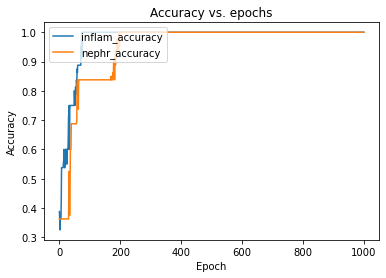

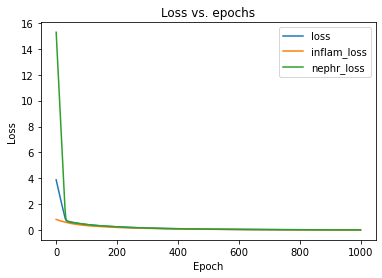

In [17]:
# Plot the training accuracy

acc_keys = [k for k in history.history.keys() if k in ('inflam_accuracy', 'nephr_accuracy')] 
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)

plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='upper left')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='upper right')

plt.show()